# Evaluate multiple models

In [1]:
import sys

import os
from os.path import join, basename
from glob import glob
from pathlib import Path

import numpy as np
import pandas as pd
from scipy.spatial import distance

import matplotlib.pyplot as plt
import plotly
import seaborn as sns

from time import time
from tqdm import tqdm

import tensorflow as tf

import cv2

import statistics
from statistics import evaluate_distance_cutoffs

import visualization
from visualization import plotly_precision_recall_slider, draw_bboxes_on_image

from prediction import prediction_utils
from data import bbox_utils as box
from data import tf_record_loading as loader
from data import image_slice_utils as slicer

## Set paths

In [2]:
GRAPH_DIR = "D:\\Nabil_object_detection\\models\\graph_imgSize_vs_bboxSize"
TEST_DIR = "D:\\Nabil_object_detection\\val"

In [3]:
# Paths for brightfield
FASTER_RCNN_10x_PATHS = glob(join(GRAPH_DIR, "faster_rcnn*10x*"))
SSD_10x_PATHS = glob(join(GRAPH_DIR, "ssd*10x*"))
TEST_DIR_10x_PATHS = glob(join(TEST_DIR, "10x*.tfrecord"))

# Paths for lensfree
FASTER_RCNN_z00_PATHS = glob(join(GRAPH_DIR, "faster_rcnn*z00*"))
SSD_z00_PATHS = glob(join(GRAPH_DIR, "ssd*z00*"))
TEST_DIR_z00_PATHS = glob(join(TEST_DIR, "z00*.tfrecord"))

In [4]:
TEST_DIR_z00_PATHS

['D:\\Nabil_object_detection\\val\\z00_tiles0_bboxes20.tfrecord',
 'D:\\Nabil_object_detection\\val\\z00_tiles0_bboxes40.tfrecord',
 'D:\\Nabil_object_detection\\val\\z00_tiles0_bboxes60.tfrecord',
 'D:\\Nabil_object_detection\\val\\z00_tiles4_bboxes20.tfrecord',
 'D:\\Nabil_object_detection\\val\\z00_tiles4_bboxes40.tfrecord',
 'D:\\Nabil_object_detection\\val\\z00_tiles4_bboxes60.tfrecord',
 'D:\\Nabil_object_detection\\val\\z00_tiles8_bboxes20.tfrecord',
 'D:\\Nabil_object_detection\\val\\z00_tiles8_bboxes40.tfrecord',
 'D:\\Nabil_object_detection\\val\\z00_tiles8_bboxes60.tfrecord']

In [5]:
# Brightfield paths
BF_BBOX20_PATHS = glob(join(GRAPH_DIR, "*10x*bboxes20"))
BF_BBOX20_TEST_PATHS = glob(join(TEST_DIR, "*10x*bboxes20.tfrecord"))

BF_BBOX40_PATHS = glob(join(GRAPH_DIR, "*10x*bboxes40"))
BF_BBOX40_TEST_PATHS = glob(join(TEST_DIR, "*10x*bboxes40.tfrecord"))

BF_BBOX60_PATHS = glob(join(GRAPH_DIR, "*10x*bboxes60"))
BF_BBOX60_TEST_PATHS = glob(join(TEST_DIR, "*10x*bboxes60.tfrecord"))

# Lensfree paths
LF_BBOX20_PATHS = glob(join(GRAPH_DIR, "*z00*bboxes20"))
LF_BBOX20_TEST_PATHS = glob(join(TEST_DIR, "*z00*bboxes20.tfrecord"))

LF_BBOX40_PATHS = glob(join(GRAPH_DIR, "*z00*bboxes40"))
LF_BBOX40_TEST_PATHS = glob(join(TEST_DIR, "*z00*bboxes40.tfrecord"))

LF_BBOX60_PATHS = glob(join(GRAPH_DIR, "*z00*bboxes60"))
LF_BBOX60_TEST_PATHS = glob(join(TEST_DIR, "*z00*bboxes60.tfrecord"))

## Predictions

In [10]:
def get_predictions(model_paths, data_paths):
    
    annotation = next(loader.tf_dataset_generator(data_paths[0]))
    image = annotation.get("image")
    gt_bboxes = annotation.get("bboxes")
    
    predictions = {}
    for i, model_path in enumerate(model_paths):

        # Parse model configs
        model_path_configuration = basename(model_path).split("_tiles")[1]
        tiles, bbox_size = model_path_configuration.split("_bboxes")

        # Load model and data
        print("Loading model:", basename(model_path))
        model = prediction_utils.load_model(model_path)

        # Predict on image
        print("Predict with tiles:", tiles)
        prediction, confidence = prediction_utils.predict_on_tiled_image(model, image, tiles=int(tiles))

        #Save prediction
        predictions[basename(model_path)] = {"prediction": prediction, "confidence": confidence}
        
    return predictions, annotation

In [11]:
# query_predictions, query_annotations = get_predictions(LF_BBOX60_PATHS, LF_BBOX60_TEST_PATHS)

## Visualiye predictions

In [12]:
def show_predictions(prediction, annotation, conf_threshold=0.5):
    
    pred = prediction.get("prediction")
    conf = prediction.get("confidence")
    
    image = annotation.get("image")
    gt_bboxes = annotation.get("bboxes")
    
    visualization.plot_bboxes_on_image(image, gt_bboxes, pred[conf >= conf_threshold])

In [13]:
# for model, prediction in query_predictions.items():
#     print(model)
#     show_predictions(prediction, query_annotations, conf_threshold=0.5)

# Precision-Recall curves

In [14]:
def convert_predictions(preds):
    
    converted_preds = {}
    
    for name, pred in preds.items():
        
        pred_yx = np.apply_along_axis(box.bbox_xy1xy2_to_yx1yx2, 1, pred.get("prediction"))
        pred_yx_sorted = pred_yx[np.argsort(pred.get("confidence"))[::-1]]
        
        converted_preds[name] = pred_yx_sorted
    
    return converted_preds

In [15]:
# query_predictions_converted = convert_predictions(query_predictions)

In [16]:
# fig = visualization.plot_precision_recall_curves(gt4_yx,
#                                            query_predictions_converted.get("faster_rcnn_resnet101_coco_z00_tiles0_bboxes60"),
#                                            query_predictions_converted.get("faster_rcnn_resnet101_coco_z00_tiles4_bboxes60"),
#                                            query_predictions_converted.get("faster_rcnn_resnet101_coco_z00_tiles8_bboxes60"),
#                                            query_predictions_converted.get("ssd_resnet50_v1_fpn_z00_tiles0_bboxes60"),
#                                            query_predictions_converted.get("ssd_resnet50_v1_fpn_z00_tiles4_bboxes60"),
#                                            query_predictions_converted.get("ssd_resnet50_v1_fpn_z00_tiles8_bboxes60"),
#                                                  title="Lensfree - BBox size 60px",
#                                            names=["Faster_Tiles0", "Faster_Tiles4", "Faster_Tiles8",
#                                                  "SSD_Tiles0", "SSD_Tiles4", "SSD_Tiles8"])

In [17]:
# # Save plot
# plot_path = "C:\\Users\\N.Jabareen\\presentations\\precision_recall_lf_bbox60.html"

# if not os.path.isfile(plot_path):
#     plotly.offline.plot(fig, filename=plot_path)
# else:
#     print("Plot already exists!!")

## Clustered cells

### Get model, annotation and prediction

In [18]:
lf_model_path = LF_BBOX40_PATHS[3]
lf_data_path = TEST_DIR_z00_PATHS[1]

bf_model_path = BF_BBOX40_PATHS[3]
bf_data_path = TEST_DIR_10x_PATHS[1]

print(f"LF CONFIGS:\nModel: {basename(lf_model_path)}\nData: {basename(lf_data_path)}\n")
print(f"BF CONFIGS:\nModel: {basename(bf_model_path)}\nData: {basename(bf_data_path)}")

LF CONFIGS:
Model: ssd_resnet50_v1_fpn_z00_tiles0_bboxes40
Data: z00_tiles0_bboxes40.tfrecord

BF CONFIGS:
Model: ssd_resnet50_v1_fpn_10x_tiles0_bboxes40
Data: 10x_tiles0_bboxes40.tfrecord


In [19]:
lf_model = prediction_utils.load_model(lf_model_path)
bf_model = prediction_utils.load_model(bf_model_path)

lf_annotation = next(loader.tf_dataset_generator(lf_data_path))
bf_annotation = next(loader.tf_dataset_generator(bf_data_path))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [20]:
lf_image = lf_annotation.get("image")
lf_gt_bboxes = lf_annotation.get("bboxes")

bf_image = bf_annotation.get("image")
bf_gt_bboxes = bf_annotation.get("bboxes")

In [36]:
lf_prediction = prediction_utils.run_inference_for_single_image(lf_model, lf_image)
bf_prediction = prediction_utils.run_inference_for_single_image(bf_model, bf_image)

In [22]:
lf_pred_bboxes, lf_pred_conf = lf_prediction.get("detection_boxes"), lf_prediction.get("detection_scores")
bf_pred_bboxes, bf_pred_conf = bf_prediction.get("detection_boxes"), bf_prediction.get("detection_scores")

AttributeError: 'NoneType' object has no attribute 'get'

### Plot predicted points and GT on image

In [ ]:
conf_thresh = 0.5

In [27]:
# lf_pred_points = box.boxes_to_center_points(lf_pred_bboxes[lf_pred_conf >= conf_thresh])
lf_gt_points = box.boxes_to_center_points(lf_gt_bboxes)

# bf_pred_points = box.boxes_to_center_points(bf_pred_bboxes[bf_pred_conf >= conf_thresh])
bf_gt_points = box.boxes_to_center_points(bf_gt_bboxes)

In [ ]:
lf_img = visualization.draw_circles_on_image(lf_image, lf_gt_points)
lf_img = visualization.draw_circles_on_image(lf_img, lf_pred_points, default_color=(0,0,255))

bf_img = visualization.draw_circles_on_image(bf_image, bf_gt_points)
bf_img = visualization.draw_circles_on_image(bf_img, bf_pred_points, default_color=(0,0,255))

In [ ]:
plt.figure(figsize=(50, 50))
plt.subplot(121)
plt.imshow(lf_img)
plt.subplot(122)
plt.imshow(bf_img)
plt.show()

### Evaluate model with points where distance of $k$ nearest neighbours $<threshold$ 

In [28]:
distance_thresholds = np.linspace(40, 130, 5)

In [29]:
lf_distnaces = distance.cdist(lf_gt_points, lf_pred_points)
k_nn = statistics.find_n_closest_points(lf_distnaces, 3)
gt_mean_dist = np.mean(k_nn, axis=1)

NameError: name 'lf_pred_points' is not defined

NameError: name 'gt_mean_dist' is not defined

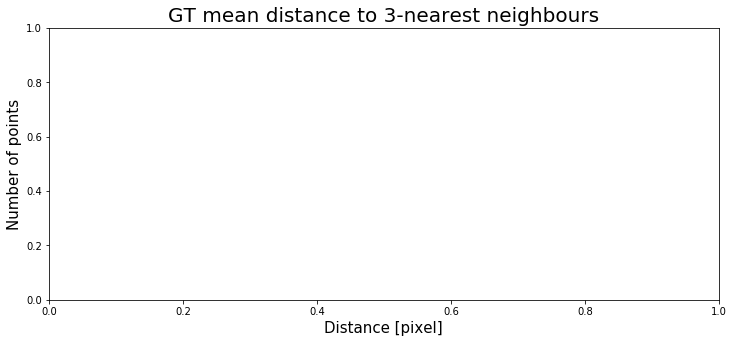

In [30]:
# GT distances with thresholds as vertival lines

plt.figure(figsize=(12,5))
plt.title("GT mean distance to 3-nearest neighbours", fontsize=20)
plt.xlabel("Distance [pixel]", fontsize=15)
plt.ylabel("Number of points", fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.hist(gt_mean_dist, bins=20)
# plt.vlines(np.mean(gt_mean_dist), 0, 60, colors="red", linewidths=5)
plt.vlines(distance_thresholds, 0, 55, linestyles="dashed", colors="red")
plt.show()

### Slider show of distance cutoffs

In [31]:
gt_dist_colors = visualization.values_to_rgb(gt_mean_dist)

NameError: name 'gt_mean_dist' is not defined

NameError: name 'gt_dist_colors' is not defined

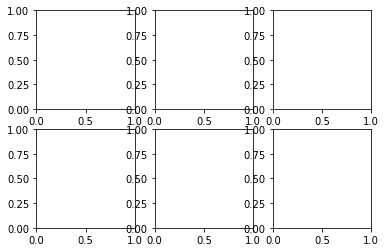

In [32]:
dist_images = []

fig, axs = plt.subplots(nrows=2, ncols=3)

for i, dt in enumerate(distance_thresholds):
    
    gt_dist_colors_np = np.array(gt_dist_colors)
    
    valid_colors = gt_dist_colors_np[gt_mean_dist <= dt]
    valid_points = lf_gt_points[gt_mean_dist <= dt]

    img = visualization.draw_circles_on_image(lf_image, valid_points, point_colors=valid_colors.tolist())
    dist_images.append(img)
    
    row = i%2
    col = i%3
    axs[row, col].imshow(img)
    
fig.set_size_inches((12, 12))

In [ ]:
# fig = visualization.plotly_image_slider(dist_images, distance_thresholds)

### Precision recall with distance cutoff

In [ ]:
conf_thresh = 0.5
lf_data_generator = loader.tf_dataset_generator(lf_data_path)

In [ ]:
for lf_annotation in lf_data_generator:

    lf_image = lf_annotation.get("image")
    lf_gt_bboxes = lf_annotation.get("bboxes")

    lf_prediction = prediction_utils.run_inference_for_single_image(lf_model, lf_image)
    lf_pred_bboxes, lf_pred_conf = lf_prediction.get("detection_boxes"), lf_prediction.get("detection_scores")

    lf_pred_points = box.boxes_to_center_points(lf_pred_bboxes[lf_pred_conf >= conf_thresh])
    lf_gt_points = box.boxes_to_center_points(lf_gt_bboxes)

    lf_knn_stats = evaluate_distance_cutoffs(lf_pred_bboxes, lf_gt_bboxes, distance_thresholds, image=lf_image)
    fig = visualization.plotly_image_slider(lf_knn_stats.get("images"), distance_thresholds)

    name = lf_annotation.get("name").decode("utf-8").split("val")[1].split(".")[0].replace("\\", "")
#     plotly.offline.plot(fig, filename=f"C:\\Users\\N.Jabareen\\presentations\\val_set_ssd_prediction\\{name}.html")
    break
    

In [ ]:
distance_thresholds

In [ ]:
lf_knn_stats = evaluate_distance_cutoffs(lf_pred_bboxes, lf_gt_bboxes, distance_thresholds, image=lf_image)
bf_knn_stats = evaluate_distance_cutoffs(bf_pred_bboxes, bf_gt_bboxes, distance_thresholds, image=bf_image)

In [ ]:
lf_knn_stats.get("precisions")

In [ ]:
lf_pre_rec = plotly_precision_recall_slider(lf_knn_stats.get("precisions"), lf_knn_stats.get("recalls"), distance_thresholds)
bf_pre_rec = plotly_precision_recall_slider(bf_knn_stats.get("precisions"), bf_knn_stats.get("recalls"), distance_thresholds)

In [ ]:
fig = visualization.plotly_image_slider(lf_knn_stats.get("images"), distance_thresholds)

In [ ]:
# plotly.offline.plot(fig, filename="C:\\Users\\N.Jabareen\\presentations\\test.html")

In [ ]:
plotly.offline.plot(lf_pre_rec, filename="C:\\Users\\N.Jabareen\\presentations\\test2.html")
plotly.offline.plot(bf_pre_rec, filename="C:\\Users\\N.Jabareen\\presentations\\test3.html")

In [2]:
import pickle
from sklearn.metrics import auc
import matplotlib.colors as mcolors
from matplotlib.pylab import setp

In [ ]:
def get_auc_from_knn(knn):
    precisions = knn.get("precisions")
    recalls = knn.get("recalls")
    aucs = [auc(r, p) for r, p in zip(precisions, recalls)]
    return aucs

In [3]:
perfomances = pickle.load(open("knn_perfomances.p", "rb"))

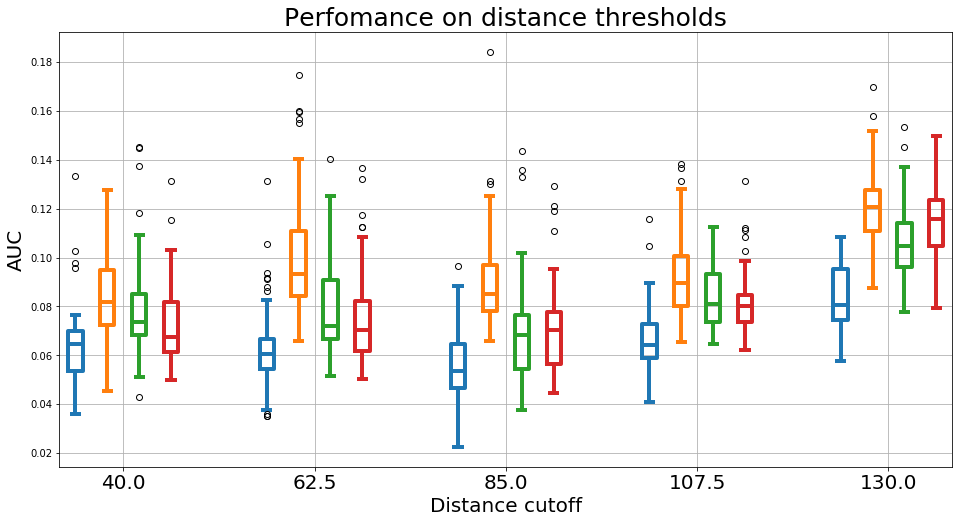

In [5]:
plot_knn_boxplot(perfomances)

In [4]:
def plot_knn_boxplot(perfomances):
    
    def setBoxColors(bp):
        colors = list(mcolors.TABLEAU_COLORS.values())[:4]

        setp(bp['boxes'][0], color=colors[0], lw=4)
        setp(bp['caps'][0], color=colors[0], lw=4)
        setp(bp['caps'][1], color=colors[0], lw=4)
        setp(bp['whiskers'][0], color=colors[0], lw=4)
        setp(bp['whiskers'][1], color=colors[0], lw=4)
        setp(bp['medians'][0], color=colors[0], lw=4)

        setp(bp['boxes'][1], color=colors[1], lw=4)
        setp(bp['caps'][2], color=colors[1], lw=4)
        setp(bp['caps'][3], color=colors[1], lw=4)
        setp(bp['whiskers'][2], color=colors[1], lw=4)
        setp(bp['whiskers'][3], color=colors[1], lw=4)
        setp(bp['medians'][1], color=colors[1], lw=4)

        setp(bp['boxes'][2], color=colors[2], lw=4)
        setp(bp['caps'][4], color=colors[2], lw=4)
        setp(bp['caps'][5], color=colors[2], lw=4)
        setp(bp['whiskers'][4], color=colors[2], lw=4)
        setp(bp['whiskers'][5], color=colors[2], lw=4)
        setp(bp['medians'][2], color=colors[2], lw=4)

        setp(bp['boxes'][3], color=colors[3], lw=4)
        setp(bp['caps'][6], color=colors[3], lw=4)
        setp(bp['caps'][7], color=colors[3], lw=4)
        setp(bp['whiskers'][6], color=colors[3], lw=4)
        setp(bp['whiskers'][7], color=colors[3], lw=4)
        setp(bp['medians'][3], color=colors[3], lw=4)

    def get_auc_from_knn(knn):
        precisions = knn.get("precisions")
        recalls = knn.get("recalls")
        aucs = [auc(r, p) for r, p in zip(precisions, recalls)]
        return aucs
    
    model_perfomances = {k: [] for k in perfomances.keys()}

    for i in range(75):
        for model, metric in perfomances.items():
            aucs = get_auc_from_knn(metric.get("knn")[i])
            model_perfomances[model].append(aucs)

    aucs = np.array([np.array(value).reshape(5, 75) for value in model_perfomances.values()])
    
    initial_pos = np.array([1, 2, 3, 4])
    max_pos = 0
    model_id = initial_pos.tolist() * 5
    distance_thresholds = np.linspace(40, 130, 5)

    plt.figure(figsize=(16,8))
    plt.title("Perfomance on distance thresholds", fontsize=25)
    for d_cutoff in range(aucs.shape[1]):
        positions = initial_pos + max_pos + 2
        max_pos = np.max(positions)

        box_data = aucs[:, d_cutoff, :].tolist()

        box = plt.boxplot(box_data, positions=positions)
        box = setBoxColors(box)
    
    plt.xticks(ticks=[4.5, 10.5, 16.5, 22.5, 28.5], labels=distance_thresholds, fontsize=20)
    # plt.yticks(np.linspace(0.5, 1, 6), fontsize=20)
    plt.ylabel("AUC", fontsize=20)
    plt.xlabel("Distance cutoff", fontsize=20)
    plt.grid()
    plt.show()

In [ ]:
model_perfomances = {k: [] for k in perfomances.keys()}

for i in range(75):
    for model, metric in perfomances.items():
        aucs = get_auc_from_knn(metric.get("knn")[i])
        model_perfomances[model].append(aucs)

In [ ]:
aucs = np.array([np.array(value).reshape(5, 75) for value in model_perfomances.values()])

In [ ]:
def setBoxColors(bp):
    colors = list(mcolors.TABLEAU_COLORS.values())[:4]

    setp(bp['boxes'][0], color=colors[0], lw=4)
    setp(bp['caps'][0], color=colors[0], lw=4)
    setp(bp['caps'][1], color=colors[0], lw=4)
    setp(bp['whiskers'][0], color=colors[0], lw=4)
    setp(bp['whiskers'][1], color=colors[0], lw=4)
    setp(bp['medians'][0], color=colors[0], lw=4)

    setp(bp['boxes'][1], color=colors[1], lw=4)
    setp(bp['caps'][2], color=colors[1], lw=4)
    setp(bp['caps'][3], color=colors[1], lw=4)
    setp(bp['whiskers'][2], color=colors[1], lw=4)
    setp(bp['whiskers'][3], color=colors[1], lw=4)
    setp(bp['medians'][1], color=colors[1], lw=4)

    setp(bp['boxes'][2], color=colors[2], lw=4)
    setp(bp['caps'][4], color=colors[2], lw=4)
    setp(bp['caps'][5], color=colors[2], lw=4)
    setp(bp['whiskers'][4], color=colors[2], lw=4)
    setp(bp['whiskers'][5], color=colors[2], lw=4)
    setp(bp['medians'][2], color=colors[2], lw=4)

    setp(bp['boxes'][3], color=colors[3], lw=4)
    setp(bp['caps'][6], color=colors[3], lw=4)
    setp(bp['caps'][7], color=colors[3], lw=4)
    setp(bp['whiskers'][6], color=colors[3], lw=4)
    setp(bp['whiskers'][7], color=colors[3], lw=4)
    setp(bp['medians'][3], color=colors[3], lw=4)


In [ ]:
initial_pos = np.array([1, 2, 3, 4])
max_pos = 0
model_id = initial_pos.tolist() * 5


plt.figure(figsize=(16,8))
plt.title("Perfomance on distance thresholds", fontsize=25)
for d_cutoff in range(aucs.shape[1]):
    positions = initial_pos + max_pos + 2
    max_pos = np.max(positions)
    
    box_data = aucs[:, d_cutoff, :].tolist()
        
    box = plt.boxplot(box_data, positions=positions)
    box = setBoxColors(box)
        
plt.xticks(ticks=[4.5, 10.5, 16.5, 22.5, 28.5], labels=distance_thresholds, fontsize=20)
# plt.yticks(np.linspace(0.5, 1, 6), fontsize=20)
plt.ylabel("AUC", fontsize=20)
plt.xlabel("Distance cutoff", fontsize=20)
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(16,8))
plt.title("Model Perfomance", fontsize=25)


    
box = plt.boxplot(m[i], positions=, widths=0.5)
        


plt.show()

In [5]:
from pathlib import Path
import pickle

In [21]:
from matplotlib import colors as mpl_colors

In [42]:
def plot_lines(data, colors=None, labels=None, title="", x_label="", y_label="", save=None):

    colors = list(mpl_colors.TABLEAU_COLORS.values())[:len(data)] if not colors else colors
    labels = list(range(len(data))) if not labels else labels

    plt.figure(figsize=(16, 8))
    plt.title(title, fontsize=25)
    for d, c, l in zip(data, colors, labels):
        plt.plot(d, linewidth=5, color=c, label=l, alpha=0.8)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel(x_label, fontsize=20)
    plt.ylabel(y_label, fontsize=20)
    plt.legend(fontsize=20)
    plt.grid()
    plt.savefig(save) if save else plt.show()


In [43]:
evaluation_path = Path("D:\\Nabil_object_detection\\models\\graph_faster_rcnn_resnet50\\Evaluation")

metirc_files = [x for x in evaluation_path.rglob("metrics.p")]

In [48]:
a = metirc_files[0]

In [53]:
a.parent.name

'faster_rcnn_resnet50_10x'

In [44]:
aucs = []
for met_path in metirc_files:
    p = pickle.load(met_path.open("rb"))
    aucs.append(p.get("aucs"))

In [45]:
out = Path.cwd().joinpath("image.png")
out

WindowsPath('D:/projects/single_cell_detection/image.png')

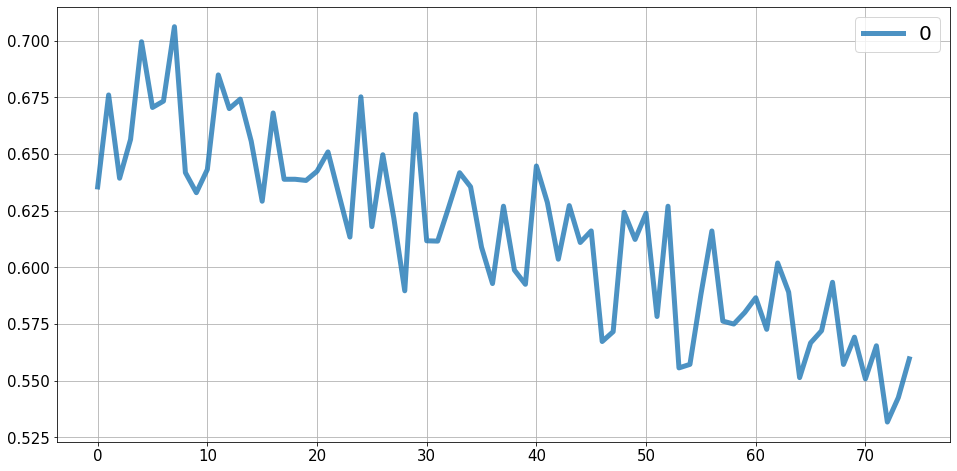

In [46]:
plot_lines(aucs, save=out)

In [56]:
from matplotlib.pylab import setp

In [57]:
def plot_simple_boxplot(boxes, colors=None, labels=None, title="", y_label="", save=None):

    colors = list(mpl_colors.TABLEAU_COLORS.values())[:len(boxes)] if not colors else colors
    labels = list(range(len(boxes))) if not labels else labels

    plt.figure(figsize=(16, 8))
    plt.title(title, fontsize=25)
    for i, (b, c, l) in enumerate(zip(boxes, colors, labels)):
        box = plt.boxplot(b, positions=[i], widths=0.5)
        for box_property in box.values():
            setp(box_property, color=c, lw=4)
    plt.xticks(ticks=list(range(len(boxes))), labels=labels, fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylabel(y_label, fontsize=20)
    plt.grid(axis="y")
    plt.savefig(save) if save else plt.show()


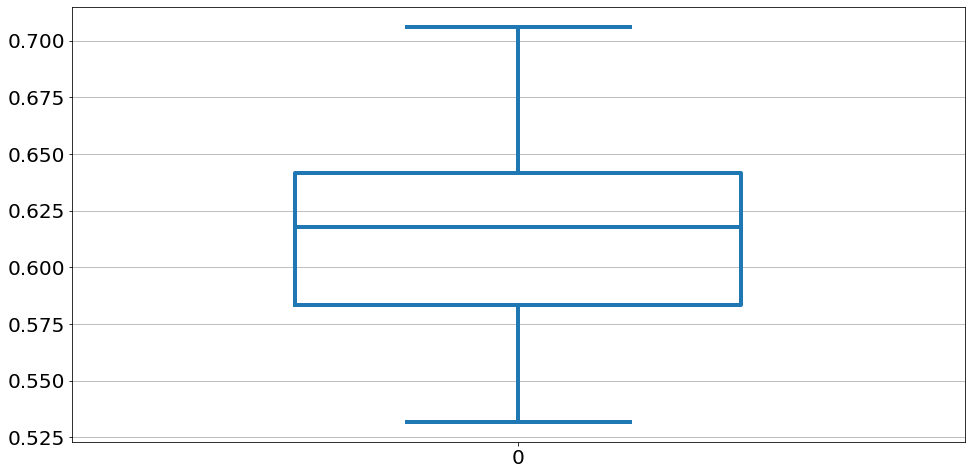

In [58]:
plot_simple_boxplot(aucs)

In [6]:
DIR_NRK = Path(r"D:\Nabil_object_detection\models\graph_generalization_trained_on_nrk")
MODEL_NRK = [x for x in DIR_NRK.glob("faster*") if x.is_dir()]
DATA_NRK = Path(r"D:\Nabil_object_detection\cell_type\nrk")

DIR_3T3 = Path(r"D:\Nabil_object_detection\models\graph_resnet50")
MODEL_3T3 = [x for x in DIR_3T3.glob("faster*") if x.is_dir()]
DATA_3T3 = Path(r"D:\Nabil_object_detection\cell_type\3t3")

MODELS = MODEL_NRK + MODEL_3T3

In [ ]:
dict_perfomance = {
    "microscopy": [],
    "cells": [],
    "auc": []
}

for model_path in MODELS:

    microscopy = model_path.name[-3:]
    
    if "nrk" in model_path.parent.name:
        cells = "nrk"
        model_name = f"{microscopy}_nrk"      
        gt_path = next(DATA_NRK.glob(f"{microscopy}*"))    
    else:
        cells = "3t3"
        model_name = f"{model_path.name[-3:]}_3t3"
        gt_path = next(DATA_3T3.glob(f"{microscopy}*"))    
        
    data_generator = loader.tf_dataset_generator(str(gt_path))       
    
    print(f"Loading {model_name}...")
    model = prediction_utils.load_model(str(model_path))
    
    
    for i in range(60):
        
        query = next(data_generator)
        
        image, gt_bboxes = query.get("image"), query.get("bboxes")
        
        prediction = prediction_utils.run_inference_for_single_image(model, image)
        
        pred_bboxes, pred_scores = prediction.get("detection_boxes"), prediction.get("detection_scores")
    
        metrics = statistics.get_performance_metrics(pred_bboxes, gt_bboxes, 0.5)
        auc = metrics.get("auc")

        dict_perfomance.get("microscopy").append(microscopy)
        dict_perfomance.get("cells").append(cells)
        dict_perfomance.get("auc").append(auc)
        
        print(f"Predict: {i+1}/{60} - AUC: {auc}", end="\r")

Loading 10x_nrk...
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
df = pd.DataFrame(dict_perfomance)

In [ ]:
plt.figure(figsize=(12, 12))
ax = sns.boxplot(x="cells", y="auc", hue="microscopy",
                 data=df, palette="Set2")
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel("Trained on:", fontsize=25)
plt.ylabel("Area Under Curve", fontsize=25)
plt.yticks(fontsize=20)
plt.show()